In [1]:
import os, glob
import shutil 

import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, concatenate, Input
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


## AlexNet

In [16]:
# 여기에서 이제 사진 들어오는 곳인데 우리꺼 np를 받아서 카테고리 별로 돌리면 될듯 
np.random.seed(1000)

#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
# valid = 입력값보다 출력값을 작게 만들어 주는거 
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))

# [?,6,6,96], [11,11,96,256].
# ValueError: Negative dimension size caused by subtracting 11 from 6 for 'conv2d_11/Conv2D' (op: 'Conv2D') with input shapes: [?,6,6,96], [11,11,96,256].


# 2nd Convolutional Layer
# strides = 움직이는 정도 (matrix가 움직이는 정도)
model.add(Conv2D(filters=256, kernel_size=(11,11), padding='valid'))

model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096)) # , input_shape=(224*224*3,)
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(30))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 384)        

In [17]:
history = model.fit(x_train, y_train, epochs=2, validation_split=0.3)

Train on 16800 samples, validate on 7200 samples
Epoch 1/2
16800/16800 [==============================] - 914s 54ms/sample - loss: 3.3060 - acc: 0.0464 - val_loss: 8.6057 - val_acc: 0.0000e+00
Epoch 2/2
16800/16800 [==============================] - 1049s 62ms/sample - loss: 3.0559 - acc: 0.0458 - val_loss: 8.9181 - val_acc: 0.0000e+00


6089/6089 [==============================] - 73s 12ms/sample - loss: 4.7890 - acc: 0.0328
loss (cross-entropy) : 4.789027981970341
test accuracy : 0.032846116


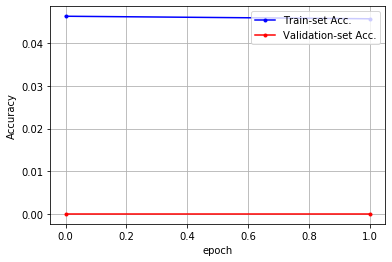

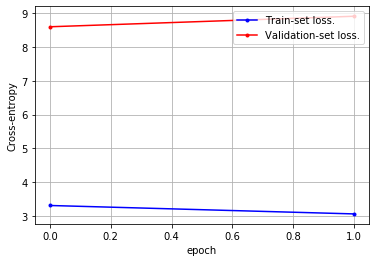

In [18]:
result = model.evaluate(x_test, y_test)
print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']

acc = history.history['acc']
val_acc = history.history['val_acc']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

## DenseNet
- 2017년 CVPR Best Paper Award 수상
- CNN 구조
- "Densely Connected Convolutional Networks"


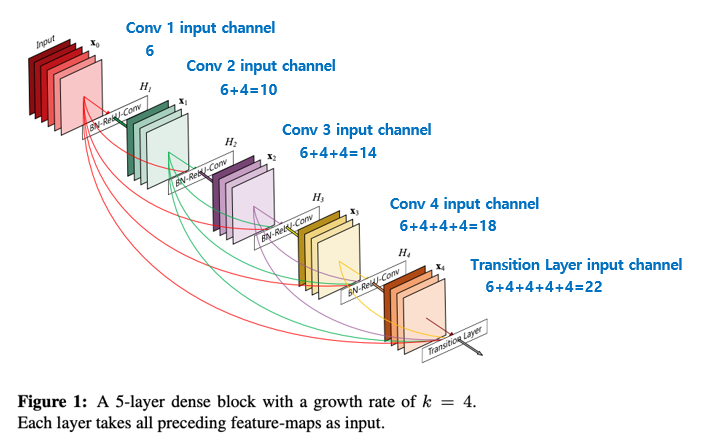

이전 layer들의 feature map을 계속해서 다음 layer의 입력과 연결하는 방식이며 이러한 방식은 ResNet에서도 사용이 되었습니다. 다만 ResNet은 feature map 끼리 더하기 를 해주는 방식이었다면 DenseNet은 feature map끼리 Concatenation 을 시키는 것이 가장 큰 차이점입니다.

이러한 구조를 통해 얻을 수 있는 이점은 다음과 같습니다.

> Vanishing Gradient 개선  
Feature Propagation 강화  
Feature Reuse  
Parameter 수 절약  

#### 논문
- Densely Connected Convolutional Networks (Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger)
    - https://arxiv.org/abs/1608.06993

#### 웹사이트
- CIFAR_10 DenseNet
    - https://blog.naver.com/jlmaj_sim/221358084087

- DenseNet Tutorial 1 Paper Review & Implementation details
    - https://hoya012.github.io/blog/DenseNet-Tutorial-1/

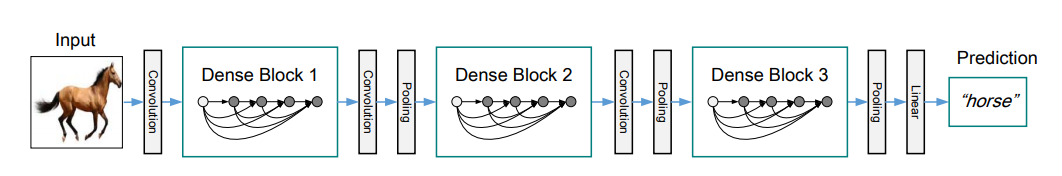

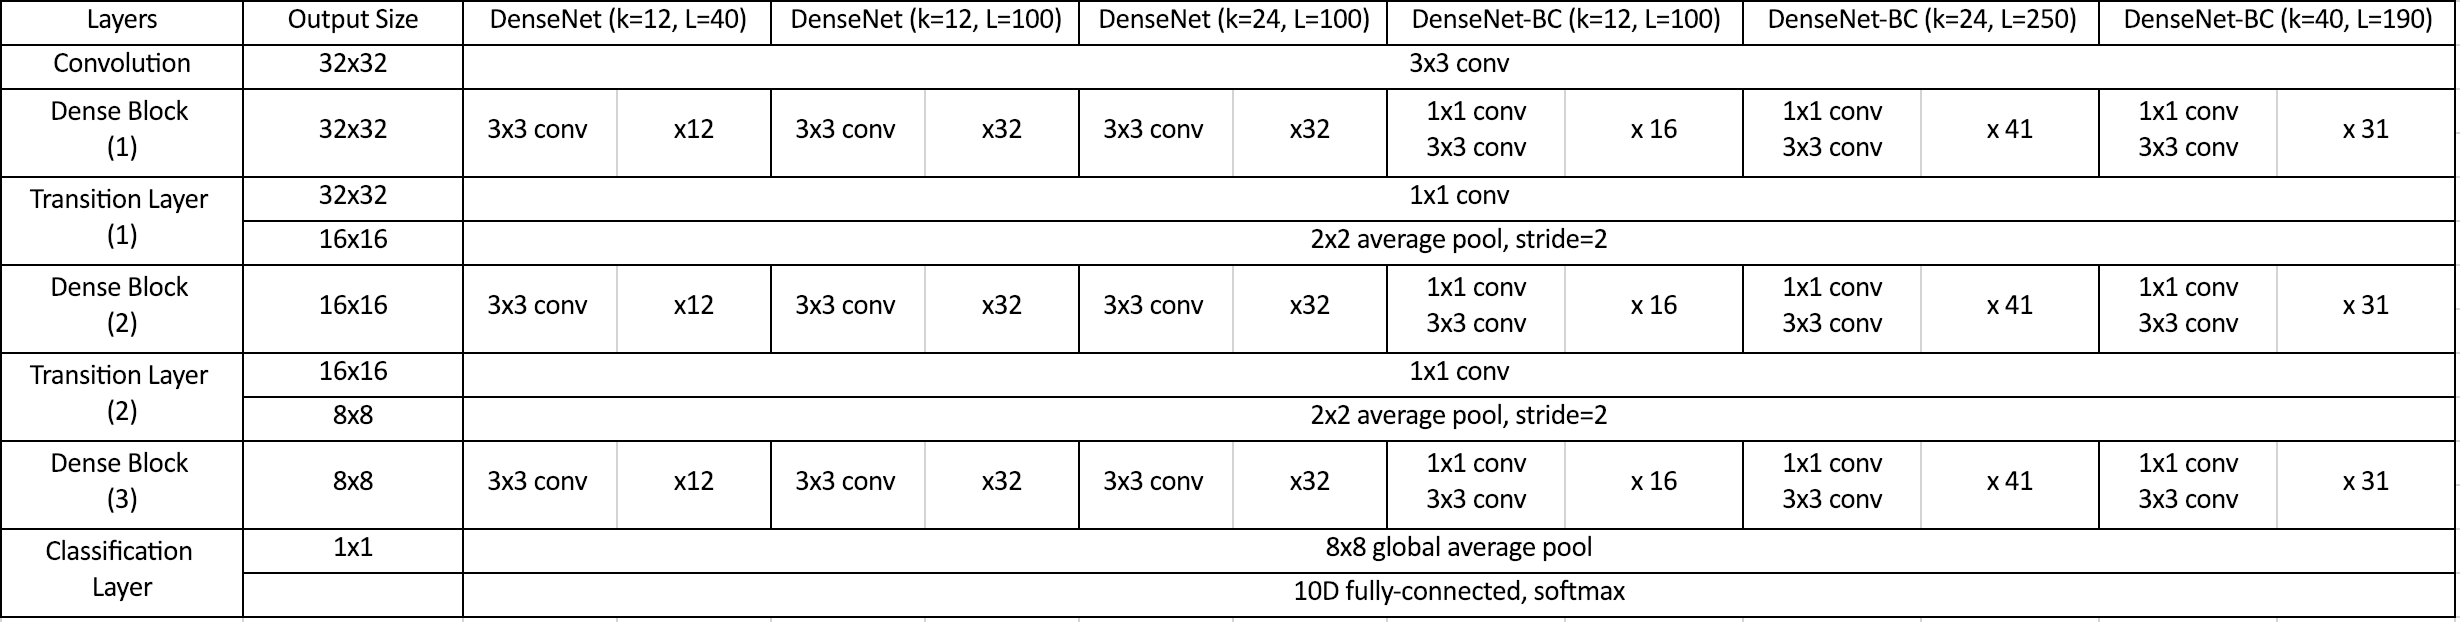

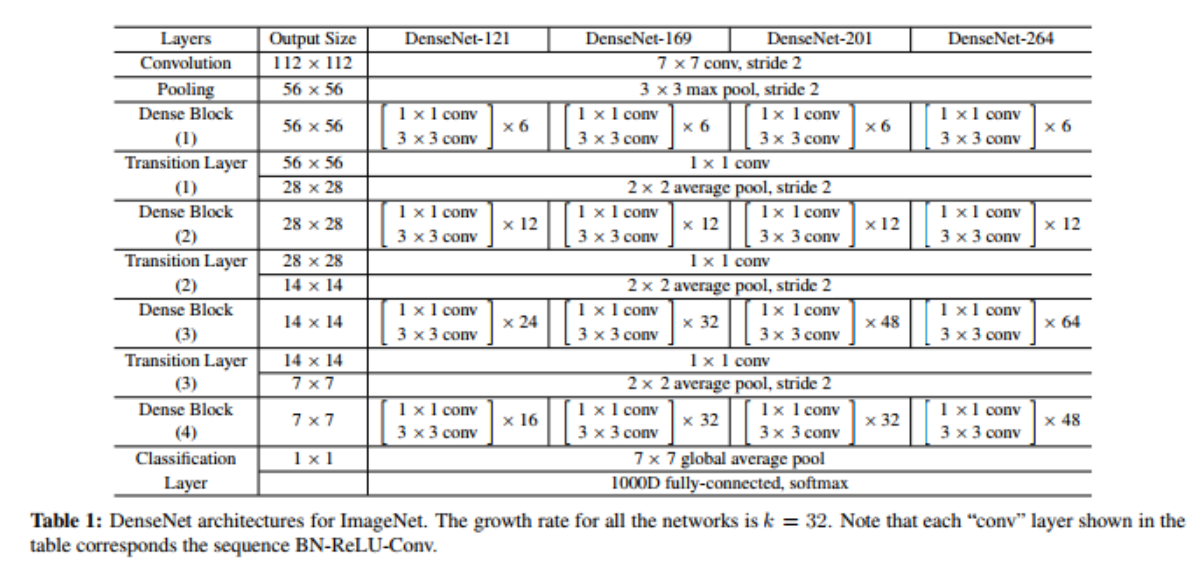

# 음식 10개

In [26]:
food_list = ['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

In [14]:
image_folder = 'top10_음식'
img_path = image_folder + '/'

In [42]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# 'train'
for food in food_list:
    print(food)
    print()
    
    food_path = img_path + food + '/'
    images = glob.glob(food_path+'/*')
    for i in images:
        img = load_img(i)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1, ) + img_array.shape)

        count= 0
        food_num = images[0].split('\\')[1].split('_')[1]
#             print(food_num)
        
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=food_path , save_prefix='Img_'+food_num, save_format='jpg'):
            count += 1
            if count > 20:
                break

갈비구이

제육볶음

짬뽕

삼겹살

짜장면

삼계탕

불고기

곰탕_설렁탕

칼국수

훈제오리



In [46]:
img_path

'top10_음식/'

In [48]:
## 사진 사이즈 변경해서 np array로 변경

image_size = 32

x_train = []
x_test = []
y_train = []
y_test = []

for tt in ['train', 'test']:
    print(tt)
    for i, food in enumerate(food_list):
        path = img_path + food + '/' + tt 
        print(food, end = ',')
         
        files = []
        files.extend(glob.glob(path + '/*'))

        for file in files:
            img = Image.open(file)
            img = img.convert("RGB") # 색상 모드 변경
            img = img.resize((image_size, image_size)) # 이미지 크기 변경

            data = np.asarray(img)
            
            globals()['x_{}'.format(tt)].append(data)
            globals()['y_{}'.format(tt)].append(i)
    print()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

train
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,
test
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [49]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4298, 32, 32, 3), (4298,), (2007, 32, 32, 3), (2007,))

In [50]:
y_train_reshape = y_train.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4298, 32, 32, 3), (4298,), (2007, 32, 32, 3), (2007,))

In [51]:
x_train = np.array(x_train) / 127.5 - 1
x_test = np.array(x_test) / 127.5 - 1

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.2)

In [58]:
history = dense121.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 1,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

108/108 [==============================] - 133s 1s/step - loss: 80.8440 - acc: 0.5032 - val_loss: 51.3105 - val_acc: 0.0977


In [59]:
history = dense121.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 100,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/100
108/108 [==============================] - 58s 536ms/step - loss: 34.0305 - acc: 0.6859 - val_loss: 24.5924 - val_acc: 0.1058
Epoch 2/100
108/108 [==============================] - 59s 542ms/step - loss: 16.7379 - acc: 0.7490 - val_loss: 13.8681 - val_acc: 0.1988
Epoch 3/100
108/108 [==============================] - 59s 545ms/step - loss: 9.6522 - acc: 0.7816 - val_loss: 9.0470 - val_acc: 0.3895
Epoch 4/100
108/108 [==============================] - 59s 544ms/step - loss: 6.3729 - acc: 0.7900 - val_loss: 6.2347 - val_acc: 0.4965
Epoch 5/100
108/108 [==============================] - 59s 547ms/step - loss: 4.4626 - acc: 0.8336 - val_loss: 4.2728 - val_acc: 0.6814
Epoch 6/100
108/108 [==============================] - 62s 574ms/step - loss: 3.4205 - acc: 0.8665 - val_loss: 3.1850 - val_acc: 0.8616
Epoch 7/100
108/108 [==============================] - 62s 570ms/step - loss: 2.7577 - acc: 0.9002 - val_loss: 2.8144 - val_acc: 0.8000
Epoch 8/100
108/108 [=======================

108/108 [==============================] - 75s 692ms/step - loss: 0.3196 - acc: 0.9895 - val_loss: 0.3162 - val_acc: 0.9907
Epoch 74/100
108/108 [==============================] - 76s 704ms/step - loss: 0.3201 - acc: 0.9889 - val_loss: 0.2941 - val_acc: 0.9942
Epoch 75/100
108/108 [==============================] - 75s 691ms/step - loss: 0.3206 - acc: 0.9901 - val_loss: 0.3189 - val_acc: 0.9872
Epoch 76/100
108/108 [==============================] - 76s 703ms/step - loss: 0.3156 - acc: 0.9901 - val_loss: 0.3233 - val_acc: 0.9860
Epoch 77/100
108/108 [==============================] - 77s 717ms/step - loss: 0.2933 - acc: 0.9933 - val_loss: 0.2825 - val_acc: 0.9953
Epoch 78/100
108/108 [==============================] - 56274s 521s/step - loss: 0.2861 - acc: 0.9956 - val_loss: 0.2751 - val_acc: 0.9965
Epoch 79/100
108/108 [==============================] - 83s 766ms/step - loss: 0.2947 - acc: 0.9907 - val_loss: 0.2727 - val_acc: 0.9988
Epoch 80/100
108/108 [==============================

In [61]:
dense121.save('denseNet_top10_food.h5')
# del model

# model = tf.keras.models.load_model('transfer_resnet50.h5')
# predictions = model.predict(test_images)
# print(predictions)

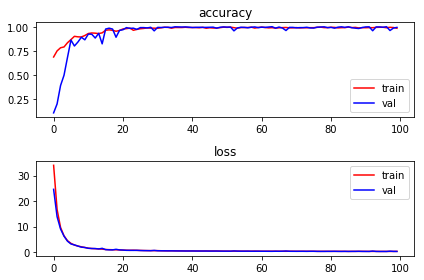

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")


plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")


plt.tight_layout()
plt.show()